This project aims to generate the captions of the images 

## Model Architecture

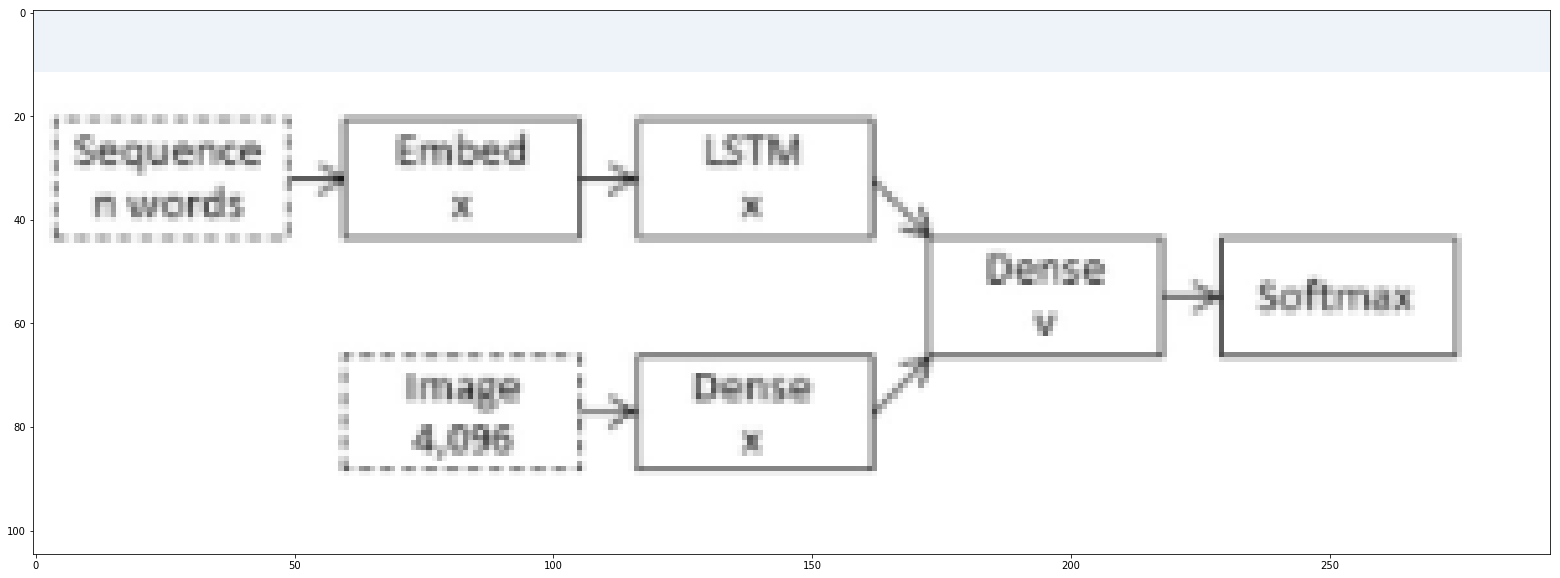

In [12]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(50,10))
image = plt.imread('Img_captioning_model.png')
plt.imshow(image)

The image is first fed to a VGG network(last layer removed) which outputs features of images(an array of length 4096).The feature array is then fed to the Dense(x) layer.The captions of the images is first enocded to sequences with the help of tokenizer class of Keras and then fed to Embedding layer and then to LSTM layer. The outputs of Dense(x) and LSTM is combined using add function and then fed to a Dense layer.At last we have a Softmax layer for making predictions.

In [1]:
from zipfile import ZipFile
import numpy as np

In [ ]:
with ZipFile('Data/Flickr8k_Dataset.zip','r') as zip:
    zip.extractall()

In [2]:
import matplotlib.pyplot as plt
import os

In [3]:
from os import listdir,path
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img,img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

Using TensorFlow backend.


In [4]:
#define the model
model = VGG16()
#Restructure the model
model.layers.pop()
model1 = Model(inputs=model.input,outputs=model.layers[-1].output)
#Summarize
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
def extract_features(directory,model):
    #Extract features from each photo
    features = dict()
    for name in listdir(directory):
        #load the image from file
        filename = path.join(directory,name)
        image = load_img(filename,target_size=(224,224))
        #Convert image pixels to numpyt array
        image = img_to_array(image)
        #Reshape data for model
        image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
        #Prepare the image for VGG model
        image = preprocess_input(image)
        #get features
        feature = model.predict(image,verbose=0)
        # get image id
        image_id = name.split(',')[0]
        #store feature
        features[image_id]= feature
        print('>%s' % name)
    return features    

In [ ]:
# extract features from all images
directory = 'Flicker8k_Dataset'
photo_features = extract_features(directory,model1)

In [ ]:
print('Extracted Features: %d' % len(photo_features))
dump(photo_features, open('features.pkl', 'wb'))

In [6]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

In [7]:
def load_doc(filename):
    file = open(filename,'r')
    text = file.read()
    file.close()
    return text

In [8]:
#Load a predefined list of photo Identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    #process line by line
    lines = doc.split('\n')
    for line in lines[:len(lines)-1]:
        #skip empty lines
        if len(line) < 1:
            continue
        #get the image identifier
        #identifier = line.split('.')[0]
        identifier = line
        dataset.append(identifier)
    return set(dataset)

In [9]:
def load_clean_descriptions(filename,dataset):
    #load dataset
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
    #split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0]+'.jpg', tokens[1:]
        # skip images not in the set
        if image_id in dataset:
        # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

In [10]:
# load training dataset (6K)
filename = 'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [11]:
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions),type(train_descriptions))

Descriptions: train=6000 <class 'dict'>


In [12]:
photo_features = load(open('features.pkl','rb'))

In [13]:
# load clean descriptions into memory
def load_photo_features(dataset,photo_features):
    #filter features
    features1 = {}
    for k in dataset:
        if k in list(photo_features.keys()): 
            features1 = {k:photo_features[k] for k in dataset}
    return features1

In [14]:
print(len(photo_features.keys()))
print(len(list(train)))

8091
6000


In [15]:
# photo features
train_features = load_photo_features(train,photo_features)
print('Photos: train_features=%d' % len(train_features))

Photos: train_features=6000


In [16]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [17]:
# fit a tokenizer to given caption of descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [18]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [19]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        # walk through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return array(X1), array(X2), array(y)

In [20]:
def define_model(vocab_size, max_length):
    
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    model.summary()
    #plot_model(model, to_file='Image_captioning_model.png', show_shapes=True)
    return model

In [21]:
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Vocabulary Size: 7579
Description Length: 34


In [22]:
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features)

In [23]:
# load test set
filename = 'Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

# photo features
test_features = load_photo_features(test,photo_features)
print('Photos: test=%d' % len(test_features))

# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features)



Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [24]:
# define the model
model1 = define_model(vocab_size, max_length)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [25]:
# define checkpoint callback
checkpoint = ModelCheckpoint('Image_captioning_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [26]:
# fit model
#Total epochs = 6+2+4+5
history=model1.fit([X1train, X2train], ytrain, epochs=20, verbose=1, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest),batch_size=int(X1train.shape[0]/32))

Train on 306404 samples, validate on 50903 samples
Epoch 1/20
306404/306404 [==============================] - 77s 251us/step - loss: 6.2086 - val_loss: 5.5177

Epoch 00001: val_loss improved from inf to 5.51772, saving model to Image_captioning_model.h5
Epoch 2/20
306404/306404 [==============================] - 75s 246us/step - loss: 5.3623 - val_loss: 5.1229

Epoch 00002: val_loss improved from 5.51772 to 5.12289, saving model to Image_captioning_model.h5
Epoch 3/20
306404/306404 [==============================] - 75s 246us/step - loss: 4.9794 - val_loss: 4.9201

Epoch 00003: val_loss improved from 5.12289 to 4.92008, saving model to Image_captioning_model.h5
Epoch 4/20
306404/306404 [==============================] - 76s 246us/step - loss: 4.7219 - val_loss: 4.7047

Epoch 00004: val_loss improved from 4.92008 to 4.70473, saving model to Image_captioning_model.h5
Epoch 5/20
306404/306404 [==============================] - 76s 247us/step - loss: 4.4386 - val_loss: 4.4913

Epoch 00005

dict_keys(['val_loss', 'loss'])

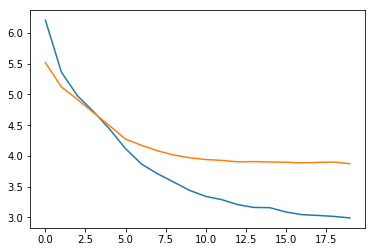

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
history.history.keys()

In [27]:
#map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [28]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for _ in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [29]:
# remove start/end sequence tokens from a summary
def cleanup_summary(summary):
    # remove start of sequence token
    index = summary.find('startseq ')
    if index > -1:
        summary = summary[len('startseq '):]
    # remove end of sequence token
    index = summary.find(' endseq')
    if index > -1:
        summary = summary[:index]
    return summary

In [34]:
# load test set
path = 'Image Captioning using Transfer Learning/'
filename = path+'Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

Dataset: 1000


In [35]:
# descriptions
test_descriptions = load_clean_descriptions(path+'descriptions.txt',test)
print('Descriptions: test=%d' % len(test_descriptions))

# photo features
test_features = load_photo_features(test,photo_features)
print('Photos: test=%d' % len(test_features))

Descriptions: test=1000
Photos: test=1000


In [36]:
# load the model
filename = path+'Image_Captioning_model.h5'
model1 = load_model(filename)

## Test few images

Text(0.5,1,'brown dog is running in the grass')

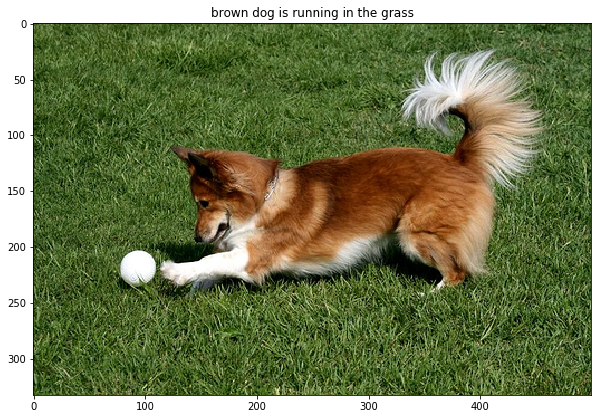

In [67]:
path = 'Image Captioning using Transfer Learning/'
figure = plt.figure(figsize=(10,10))
description = generate_desc(model1, tokenizer,list(test_features.values())[3], max_length)
description = cleanup_summary(description)
directory = path+'Flicker8k_Dataset'
location = directory+'/'+list(test_features.keys())[3]
image = plt.imread(location)
plt.imshow(image)
plt.title(description)

Text(0.5,1,'the boat is towed on the water')

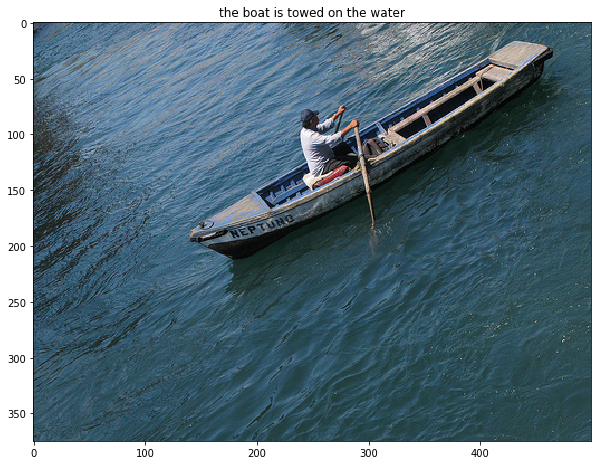

In [68]:
path = 'Image Captioning using Transfer Learning/'
figure = plt.figure(figsize=(10,10))
description = generate_desc(model1, tokenizer,list(test_features.values())[5], max_length)
description = cleanup_summary(description)
directory = path+'Flicker8k_Dataset'
location = directory+'/'+list(test_features.keys())[5]
image = plt.imread(location)
plt.imshow(image)
plt.title(description)

Text(0.5,1,'man in yellow helmet rides his bike on street')

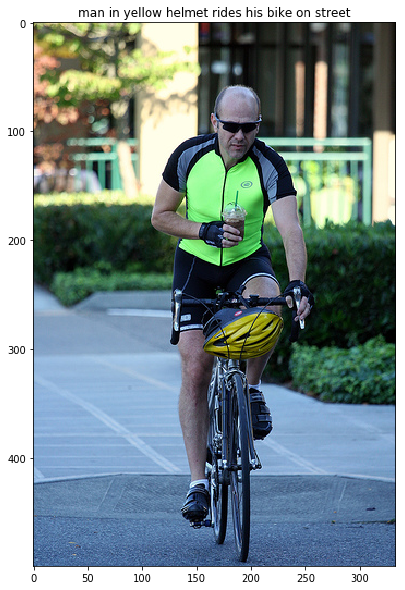

In [73]:
path = 'Image Captioning using Transfer Learning/'
figure = plt.figure(figsize=(10,10))
description = generate_desc(model1, tokenizer,list(test_features.values())[15], max_length)
description = cleanup_summary(description)
directory = path+'Flicker8k_Dataset'
location = directory+'/'+list(test_features.keys())[15]
image = plt.imread(location)
plt.imshow(image)
plt.title(description)